# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *

PATH = "data/demand-forecasting/"

# Helper Functions

In [3]:
def rmse(y_true, y_pred):
    return math.sqrt(((y_pred-y_true)**2).mean())

In [4]:
def smape(y_pred,y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# EDA

In [ ]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'])

In [ ]:
display(train.head(1))
display(train.tail(1))

display(test.head(1))
display(test.tail(1))

In [ ]:
# DataFrameSummary(train).summary()
# DataFrameSummary(test).summary()

# train.info()
# test.info()

In [ ]:
len(train[train.sales==0])

In [ ]:
len(train[train.sales<train.sales.quantile(0.01)]), len(train[train.sales<train.sales.quantile(0.001)])

In [ ]:
len(train[train.sales>train.sales.quantile(0.99)]), len(train[train.sales>train.sales.quantile(0.999)])

In [ ]:
# exclude certain rows
# train = train[train.sales!=0]

#train = train[(train.sales>train.sales.quantile(q=0.001)) & (train.sales<train.sales.quantile(q=0.999))]

In [ ]:
# train.reset_index(drop=True,inplace=True)
# test.reset_index(drop=True,inplace=True)

In [ ]:
train.to_feather(f'{PATH}train_raw')
test.to_feather(f'{PATH}test_raw')

# Data Cleaning and Feature Engineering

In [5]:
train = pd.read_feather(f'{PATH}train_raw')
test = pd.read_feather(f'{PATH}test_raw')

In [6]:
use_all_data = 0
validation_data_mode = 1

In [7]:
cat_vars = ['store', 'item', 'Month', 'Week', 'Day','Dayofweek', 'Dayofyear']
contin_vars = ['Year', 'Elapsed'] 

# Elapsed = Unix Timestamp ( 0 = 1 Jan 1970 12.00am and can be negative)
# Discared date categorical variables
# 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start','Is_year_end', 'Is_year_start'

In [8]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)

In [9]:
# Reorg train and test dataset
dependent = 'sales'
train = train[cat_vars+contin_vars+[dependent, 'date']].copy()

test[dependent] = 0 # broadcast zero for 'Sales' dummy col
test = test[cat_vars+contin_vars+[dependent, 'date', 'id']].copy()

In [10]:
n = len(train)

In [11]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [12]:
apply_cats(test, train)

In [13]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [14]:
if use_all_data == 0:
    # Get a sample m from all training data
    m = 200000
    idxs = get_cv_idxs(n, val_pct=m/n) # get random sample by index, nothing to do with validation
    train_samp = train.iloc[idxs].set_index("date")
    sample_size = len(train_samp)
    sample_size
elif use_all_data == 1:
    # Set sample size equal to total data to use all data
    sample_size = n
    train_samp = train.set_index("date")
else:
    pass
    #raise Exception()

In [15]:
len(train_samp), len(train), len(test)

(200000, 913000, 45000)

In [16]:
df_train, y_train, nas, mapper = proc_df(train_samp, 'sales', do_scale=True)

In [17]:
test = test.set_index("date")

df_test, _, nas, mapper = proc_df(test, 'sales', do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In [18]:
if validation_data_mode == 0:
    val_idx = [0]
elif validation_data_mode == 1:
    val_idx = np.flatnonzero(
        (df_train.index>=datetime.datetime(2017,10,1)) & (df_train.index<=datetime.datetime(2017,12,31)))
elif validation_data_mode == 2:
    val_idx = np.flatnonzero(
        (df_train.index>=datetime.datetime(2017,1,1)) & (df_train.index<=datetime.datetime(2017,3,31)))
else:
    raise ValueError("Invalid validation_data_mode")

In [19]:
len(df_train), len(val_idx), len(df_test)

(200000, 10131, 45000)

In [21]:
len(train_samp)

200000

# Deep Learning

## Get Data

In [22]:
def get_data():
    return ColumnarModelData.from_data_frame(PATH, val_idx, 
                                             df_train, y_train.astype(np.float32), 
                                             cat_flds=cat_vars, bs=128,
                                             test_df=df_test)

In [23]:
md = get_data()

## Get Embedding Size

In [24]:
cat_sz = [(c, len(train_samp[c].cat.categories)+1) for c in cat_vars]
# cat_sz

In [25]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
# emb_szs

## Create Architecture

In [26]:
m = md.get_learner(emb_szs, # size of embeddings
                   len(df_train.columns)-len(cat_vars), # size of continuous vars
                   0.04, # embedding droput
                   1, # number of output
                   [1024,512], # fully connected layer hidden units
                   [0.001,0.01]) # fully connected layers droput

## Get Learning Rate

In [27]:
m.lr_find()

 61%|█████████████████████████████████████████▌                          | 906/1484 [00:08<00:05, 103.64it/s, loss=281]


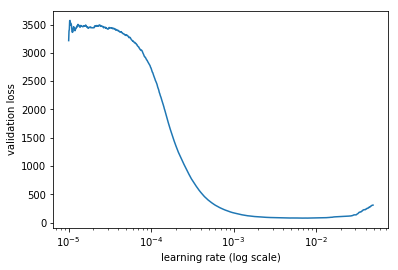

In [28]:
m.sched.plot(n_skip=0,n_skip_end=0)

In [ ]:
lr = 1e-3

## Fit on Sample Data

In [ ]:
m.fit(lr, 3, metrics=[smape, rmse])

In [ ]:
m.fit(lr, 5, cycle_len=1, metrics=[smape, rmse])

In [ ]:
m.fit(lr, 2, cycle_len=4, metrics=[smape, rmse])

In [ ]:
m.save('md_sample_trained_v1_no_val')

In [ ]:
m.load('md_sample_trained_v1_no_val')

## Fit on All Data (with/without validation)

In [ ]:
md_all_3mth_val = get_data()

In [ ]:
m.set_data(md_all_3mth_val)

In [ ]:
m.fit(lr, 3, metrics=[smape, rmse])

In [ ]:
m.fit(lr, 3, metrics=[smape, rmse])

In [ ]:
m.save('md_all_3mth_val_trained_v1_no_val')

In [ ]:
m.load('md_all_3mth_val_trained_v3')

## Loop

In [ ]:
md = get_data()
m = md.get_learner(emb_szs, # size of embeddings
                   len(df_train.columns)-len(cat_vars), # size of continuous vars
                   0.04, # embedding droput
                   1, # number of output
                   [1024,512], # fully connected layer hidden units
                   [0.001,0.01]) # fully connected layers droput
lr=1e-2
m.fit(lr, 10, metrics=[smape, rmse])

In [35]:
for i in range(5):
    
    m = 450_000
    idxs = get_cv_idxs(n, val_pct=m/n) # get random sample by index, nothing to do with validation
    train_samp = train.iloc[idxs].set_index("date")
    df_train, y_train, nas, mapper = proc_df(train_samp, 'sales', do_scale=True)
    
    val_idx = np.flatnonzero(
        (df_train.index>=datetime.datetime(2017,10,1)) & (df_train.index<=datetime.datetime(2017,12,31)))
    
    lr=5e-4
    print(f"Round {i+1}")

    md = get_data()
    m = md.get_learner(emb_szs, # size of embeddings
                       len(df_train.columns)-len(cat_vars), # size of continuous vars
                       0.001, # embedding droput
                       1, # number of output
                       [1024,512], # fully connected layer hidden units
                       [0.001,0.001]) # fully connected layers droput


    m.fit(lr, 16, metrics=[smape, rmse])

Round 1


epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      55.53449   63.057454  12.769399  7.931656  
    1      53.819436  58.445046  12.416929  7.637124                                                                   
    2      54.034881  57.202748  12.265239  7.555631                                                                   
    3      54.504813  58.386817  12.33119   7.632342                                                                   
    4      54.105913  60.075042  12.454708  7.741833                                                                   
    5      53.74105   57.481343  12.272604  7.573663                                                                   
    6      52.315792  57.412209  12.311432  7.569022                                                                   
    7      51.295641  57.634789  12.28423   7.583726                                                     

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      54.577802  59.598971  12.441973  7.712246  
    1      55.496369  57.233959  12.236618  7.55785                                                                    
    2      52.903601  57.280213  12.297394  7.560898                                                                   
    3      54.918977  60.082602  12.485374  7.743217                                                                   
    4      54.673272  57.271634  12.252703  7.560084                                                                   
    5      53.514122  59.142554  12.355695  7.681612                                                                   
    6      52.683808  59.475637  12.461267  7.703757                                                                   
    7      53.317477  57.168969  12.226239  7.553378                                                     

KeyboardInterrupt: 

In [ ]:
59~60

# Predict

In [ ]:
pred_test = m.predict(True)

In [ ]:
test2['sales'] = pred_test

In [ ]:
csv_fn=f'{PATH}tmp/ann_v1.csv'

In [ ]:
test2[['id','sales']].to_csv(csv_fn, index=False)

# Variations of Data Engineering

## Version 1 (Using 'Year' as continuous variable, removed 'Elapsed')

## Version 2 (Using 'Elapsed' as continuous variable, 'Year' as categorical)

## Version 3 (Using 'Year' and 'Elapsed' as continuous variable)

# Visualizations

## Prediction on validation data

In [ ]:
m.load('md_all_3mth_val_trained_v3')

In [ ]:
test_val = test.copy()

In [ ]:
pred_val = m.predict(False)  # predict on validation data

In [ ]:
# stick the prediction to copy of test data, and then offset by 12 months 
# because that's how our validation data is defined (2017-01-01 to 2017-03-31)
test_val['sales'] = pred_val
test_val['date'] = test_val['date'] - pd.DateOffset(months=12)

In [ ]:
test_val.drop('id',axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(30,120)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(1): #set range to 10 to show all 10 stores
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[(train.store==(store+1)) & (train.date.dt.year>2015)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_val[test_val.store==(store+1)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()

In [ ]:
plt.figure(figsize=(30,150)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(1): #set range to 10 to show all 10 stores
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[(train.store==(store+1)) 
                                                & (((train.date.dt.year==2017) & (train.date.dt.month<5))
                                                | ((train.date.dt.year==2016) & (train.date.dt.month>11)))],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_val[test_val.store==(store+1)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.grid()
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()

## Prediction on test data

In [ ]:
m.load('md_all_3mth_val_trained_v3_no_val')

In [ ]:
pred_test = m.predict(True) # predict on test data# 

In [ ]:
test_pred = test.copy()

In [ ]:
test_pred['sales'] = pred_test

In [ ]:
test_pred.drop('id',axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(30,120)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(10):
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[train.store==(store+1)],index=['date'],
                                          columns=['store',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_pred[test_pred.store==(store+1)],index=['date'],
                                          columns=['store',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()